In [20]:
from typing import *
import os
from glob import glob
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nptyping import NDArray
from IPython.display import display

# 型推定
from matplotlib.figure import Figure
from matplotlib.axes._subplots import Subplot

sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

cmap = sns.diverging_palette(255, 0, as_cmap=True)  # カラーパレットの定義

# モンティホール問題

In [8]:
class MontyHall:
    def __init__(self, doors: int = 3, hints: int = 1) -> None:
        self.doors : int = doors  # ゲームに使用するドアの数
        self.hints : int = hints  # 司会者が開けるドアの数

    def play(self, change: bool) -> int:
        """ゲームを１回行い、結果を返却"""
        prize : int = np.random.randint(self.doors)  # あたりのドア
        choice : int = 0  # プレイヤーが選択したドア
        selectable : List[bool] = [True] * self.doors  # 司会者が開くべきドア
        selectable[choice] = False
        selectable[prize] = False

        # 司会者が、選択済ドア、正解ドア以外をhints数だけオープン
        selectable_to_open : List[int] = [n for n in range(self.doors) if selectable[n]]
        random_choice : List[bool] = np.random.choice(selectable_to_open, self.hints, replace=False)
        for c in random_choice:
            selectable[c] = False

        if change:  # プレイヤーはドアを変更
            if choice != prize:
                selectable[prize] = True
            selectable_to_choose : List[bool] = [c for c in range(self.doors) if selectable[c]]
            choice = np.random.choice(selectable_to_choose, 1, replace=False)[0]

        if choice == prize:
            return 1  # あたり
        else:
            return 0  # はずれ


def trials(monty_hall: MontyHall, change: bool, num_try: int = 30000) -> float:
    """あたりを引く確率を返却"""
    results : List[int] = [monty_hall.play(change=change) for _ in range(num_try)]
    return sum(results) / num_try


monty_hall : MontyHall = MontyHall()
no_change_prob : float = trials(monty_hall=monty_hall, change=False)
change_prob : float = trials(monty_hall=monty_hall, change=True)
print(f'no change: {no_change_prob}')
print(f'change: {change_prob}')

no change: 0.3364333333333333
change: 0.6703666666666667


,doors,no change,change
0,3,0.335867,0.664333
1,4,0.247667,0.750133
2,5,0.201400,0.803300
3,6,0.165900,0.833733
4,7,0.142200,0.859367
5,8,0.125100,0.876567
6,9,0.110933,0.886633


<AxesSubplot:xlabel='doors'>

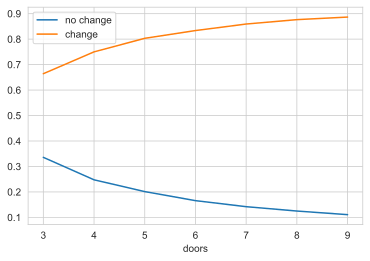

In [11]:
no_change_results : List[float] = []
change_results : List[float] = []

doors_range : List[int] = list(range(3, 10))

for doors in doors_range:
    monty_hall : MontyHall = MontyHall(doors=doors, hints=doors-2)
    no_change_results.append(trials(monty_hall=monty_hall, change=False))
    change_results.append(trials(monty_hall=monty_hall, change=True))

df : pd.DataFrame = pd.DataFrame({
    'doors': doors_range,
    'no change': no_change_results,
    'change': change_results})

display(df)

df.plot(x='doors')

# ギャンブル問題

In [26]:
State = int

class Gambler:
    def __init__(self, goal: int = 100, win_rate: float = 0.4) -> None:
        self.goal : int = goal
        self.win_rate : float = win_rate
        self.states : List[State] = list(range(goal+1))

        self.policy : Dict[State, int] = {}
        self.values : Dict[State, float] = {}
        self.cnt : Dict[State, int] = {}

        for state in self.states:
            self.values[state] = 0
            self.cnt[state] = 0
    
    def play(self, state: State, action: State) -> Tuple[int, State]:
        if (state == 0) or (state == self.goal):
            return 0, state
        if np.random.random() < self.win_rate:  # Win
            state = min(self.goal, state + action)
            if state == self.goal:
                return 1, state
            return 0, state
        else:  # Lose
            state -= action
            if state == 0:
                return -1, state
            return 0, state


def show_result(gamblers: List[Gambler], labels: Optional[List[str]] = None) -> None:
    if labels is None:
        labels = [f'policy {i+1}' for i in range(len(gamblers))]

    fig : Figure = plt.figure(figsize=(14, 4))
    subplot1 : Subplot = fig.add_subplot(1, 2, 1, xlabel='point', ylabel='policy')
    subplot2 : Subplot = fig.add_subplot(1, 2, 2, xlabel='point', ylabel='value')
    for idx, gambler in enumerate(gamblers):
        line_x : List[int] = list(range(1, gambler.goal))
        line_y : List[int] = [gambler.policy[state] for state in line_x]
        subplot1.plot(line_x, line_y, label=labels[idx])
        line_y : List[int] = [gambler.values[state] for state in line_x]
        subplot2.plot(line_x, line_y, label=labels[idx])
    subplot1.legend()
    subplot2.legend()


def get_episode(gambler: Gambler) -> List[Tuple[State, State, float]]:
    """ランダムに選択した初期状態から、終了状態に至るまでの状態変化を返却"""
    episode : List[Tuple[State, State, float]] = []
    state : State = np.random.randint(1, gambler.goal)  # 初期状態をランダムに選択
    while True:
        action : State = gambler.policy[state]
        reward, new_state = gambler.play(state=state, action=action)
        episode.append((state, action, reward))
        if (new_state == 0) or (new_state == gambler.goal):
            break
        state = new_state
    return episode


def train(gambler: Gambler, num_try: int) -> None:
    c = 0
    while c < num_try:
        episode : List[Tuple[State, State, float]] = get_episode(gambler=gambler)
        episode.reverse()
        total_reward : float = 0
        for (state, _, reward) in episode:
            total_reward += reward
            gambler.cnt[state] += 1
            gambler.values[state] += (total_reward - gambler.values[state]) / gambler.cnt[state]
        c += len(episode)

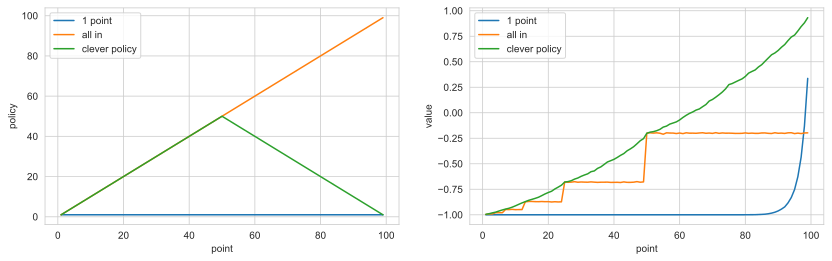

In [27]:
num_try = 10000000
trained_gamblers : List[Gambler] = []


gambler = Gambler()
# 常に１ポイントだけ賭ける
for state in gambler.states:
    gambler.policy[state] = 1
train(gambler=gambler, num_try=num_try)
trained_gamblers.append(gambler)


gambler = Gambler()
# 常に全ポイント賭ける
for state in gambler.states:
    gambler.policy[state] = state
train(gambler=gambler, num_try=num_try)
trained_gamblers.append(gambler)


gambler = Gambler()
# チップが1 ~ 50ポイントの場合はall in、 51 ~ 100の場合は100 - チップ
for state in gambler.states:
    gambler.policy[state] = min(state, gambler.goal-state)
train(gambler=gambler, num_try=num_try)
trained_gamblers.append(gambler)

# グラフ描写
show_result(gamblers=trained_gamblers, labels=['1 point', 'all in', 'clever policy'])

# サンプリングを用いた価値反復法

In [28]:
State = int

class Gambler:
    def __init__(self, goal: int = 100, win_rate: float = 0.4) -> None:
        self.goal : int = goal
        self.win_rate : float = win_rate
        self.states : List[State] = list(range(goal+1))
        self.policy : Dict[State, int] = {}
        # 行動ポリシー（ベットする金額）を乱数で設定
        for state in self.states:
            if (state == 0) or (state == self.goal):
                continue
            self.policy[state] = np.random.randint(1, state+1)
        self.q : Dict[Tuple[State, State], float] = {}  # 行動-状態価値関数q
        self.cnt : Dict[Tuple[State, State], int] = {}  # 平均値逐次計算用のカウンター
        # q, cnt のvalueを0で初期化
        for state in self.states:
            for action in range(1, state+1):
                self.q[(state, action)] = 0
                self.cnt[(state, action)] = 0

    def play(self, state: State, action: State) -> Tuple[int, State]:
        if (state == 0) or (state == self.goal):
            return 0, state
        if np.random.random() < self.win_rate:  # Win
            state = min(self.goal, state + action)
            if state == self.goal:
                return 1, state
            return 0, state
        else:  # Lose
            state -= action
            if state == 0:
                return -1, state
            return 0, state


def show_result(gamblers: List[Gambler], labels: Optional[List[str]] = None) -> None:
    if labels is None:
        labels = [f'policy {i+1}' for i in range(len(gamblers))]

    fig : Figure = plt.figure(figsize=(14, 4))
    subplot1 : Subplot = fig.add_subplot(1, 2, 1, xlabel='point', ylabel='policy')
    subplot2 : Subplot = fig.add_subplot(1, 2, 2, xlabel='point', ylabel='value')
    for idx, gambler in enumerate(gamblers):
        line_x : List[int] = list(range(1, gambler.goal))
        line_y : List[int] = [gambler.policy[state] for state in line_x]
        subplot1.plot(line_x, line_y, label=labels[idx])
        line_y : List[int] = [gambler.q[(state, gambler.policy[state])] for state in line_x]
        subplot2.plot(line_x, line_y, label=labels[idx])
    subplot1.legend()
    subplot2.legend()


def get_episode(gambler: Gambler) -> List[Tuple[State, State, float]]:
    """ランダムに選択した初期状態から、終了状態に至るまでの状態変化を返却"""
    episode : List[Tuple[State, State, float]] = []
    state : State = np.random.randint(1, gambler.goal)  # 初期状態をランダムに選択
    initial : bool = True
    while True:
        if initial:
            action : State = np.random.randint(1, state+1)  # 最初のactionは乱数で選択
            initial = False
        else:
            action = gambler.policy[state]
        reward, new_state = gambler.play(state=state, action=action)
        episode.append((state, action, reward))
        if (new_state == 0) or (new_state == gambler.goal):
            break
        state = new_state
    return episode


def policy_update(gambler: Gambler, state: State) -> None:
    """取り得る全てのactionに対するqの値を比較し、qが最大となるactionを新たな行動ポリシーとする"""
    q_max : float = -10**10
    best_action : Optional[State] = None
    for action in range(1, state+1):
        if gambler.q[(state, action)] > q_max:
            q_max = gambler.q[(state, action)]
            best_action = action
    gambler.policy[state] = best_action


def train(gambler: Gambler, num_try: int) -> None:
    c = 0
    while c < num_try:
        episode : List[Tuple[State, State, float]] = get_episode(gambler=gambler)
        episode.reverse()
        total_reward : float = 0
        for (state, action, reward) in episode:
            total_reward += reward
            gambler.cnt[(state, action)] += 1
            # 行動-状態価値関数qの更新
            gambler.q[(state, action)] += (total_reward - gambler.q[(state, action)]) / gambler.cnt[(state, action)]
            # 行動ポリシーの更新
            policy_update(gambler=gambler, state=state)
        c += len(episode)

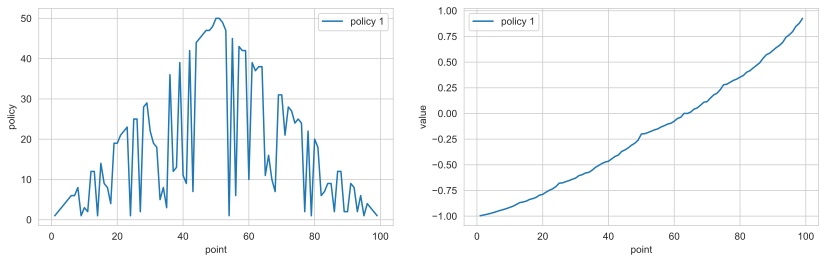

In [29]:
num_try = 50000000

gambler : Gambler = Gambler()
train(gambler=gambler, num_try=num_try)
show_result(gamblers=[gambler])

# オフポリシー

In [36]:
Maze = List[List[str]]

MAZE_IMG = '''
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#          #
#         G#
############
'''

def get_maze() -> Maze:
    maze : Maze  = []
    for line in MAZE_IMG.split('\n'):
        if line == '':
            continue 
        maze.append(list(line))
    return maze

get_maze()

[['#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#'],
 ['#', 'S', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
 ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
 ['#', '#', '#', '#', '#', '#', '#', ' ', ' ', ' ', ' ', '#'],
 ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
 ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
 ['#', ' ', ' ', ' ', ' ', '#', '#', '#', '#', '#', '#', '#'],
 ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
 ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'G', '#'],
 ['#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#']]

In [42]:
State = Tuple[int, int]

class Agent:
    def __init__(self, maze: Maze) -> None:
        self.maze = maze
        size_y, size_x = len(maze), len(maze[0])
        self.states : List[State] = [(x, y) for x in range(size_x) for y in range(size_y)]
        self.actions : List[State] = [(0, -1), (-1, 0), (1, 0), (0, 1)]
        self.policy : Dict[State, State] = {}
        self.q : Dict[Tuple(State, State), float] = {}
        self.cnt : Dict[Tuple(State, State), int] = {}
        for state in self.states:
            self.policy[state] = self.actions[np.random.randint(len(self.actions))]
            for action in self.actions:
                self.q[(state, action)] = -10**10
                self.cnt[(state, action)] = 0

    def move(self, state: State, action: State) -> Tuple[float, State]:
        x, y = state
        dx, dy = action
        if self.maze[y][x] == 'G':
            return 0, state
        if self.maze[y+dy][x+dx] != "#":
            x += dx
            y += dy
        return -1, (x, y)


def get_episode(agent: Agent, epsilon: float) -> List[Tuple[State, State, float]]:
    """startからgoalまでに至るまでの状態変化を返却"""
    episode : List[Tuple[State, State, float]] = []
    state : State = (1, 1)  # start
    while True:
        if np.random.random() < epsilon:  # 確率εでランダムなactionを選択
            action : State = agent.actions[np.random.randint(len(agent.actions))]
        else:
            action : State = agent.policy[state]

        reward, new_state = agent.move(state=state, action=action)
        episode.append((state, action, reward))
        x, y = new_state
        if agent.maze[y][x] == 'G':
            break
        state = new_state
    return episode


def policy_update(agent: Agent, state: State) -> None:
    q_max : float = -10**10
    best_action : Optional[State] = None
    for action in agent.actions:
        if agent.q[(state, action)] > q_max:
            q_max = agent.q[(state, action)]
            best_action = action
    agent.policy[state] = best_action


def train(agent: Agent, epsilon: float, min_epsilon) -> List[int]:
    episode_lengths : List[int] = []
    max_data_length : int = 0

    while True:
        episode : List[Tuple[State, State, float]] = get_episode(agent=agent, epsilon=epsilon)
        episode_lengths.append(len(episode))
        episode.reverse()
        total_reward : int = 0
        last : bool = False
        data_length : int = 0

        for (state, action, reward) in episode:
            data_length += 1
            if action != agent.policy[state]:  # 確率εで採択されたランダムなactionの場合
                last = True
            total_reward += reward
            agent.cnt[(state, action)] += 1
            agent.q[(state, action)] += (total_reward - agent.q[(state, action)]) / agent.cnt[(state, action)]
            policy_update(agent=agent, state=state)
            if last:
                break
        epsilon *= 0.999
        if epsilon < min_epsilon:
            break

        if data_length > max_data_length:
            max_data_length = data_length
            result : Maze = np.copy(agent.maze)
            for (state, action, reward) in episode[:data_length]:
                x, y = state
                result[y][x] = '+'
            print(f'epsilon = {epsilon:1.3f}')
            for line in result:
                print(''.join(line))
            print('')

    return episode_lengths

In [43]:
maze : Maze = get_maze()
agent : Agent = Agent(maze=maze)

episode_lengths : List[int] = train(agent=agent, epsilon=0.9, min_epsilon=0.01)

epsilon = 0.899
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#         +#
#         G#
############

epsilon = 0.897
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#          #
#       ++G#
############

epsilon = 0.896
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#       +  #
#       ++G#
############

epsilon = 0.891
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#          #
#     ++++G#
############

epsilon = 0.860
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#          #
#    +++++G#
############

epsilon = 0.823
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#          #
#    +++++G#
############

epsilon = 0.809
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#    ++    

In [44]:
episode : List[Tuple[Tuple[int, int]]] = get_episode(agent=agent, epsilon=0)

result = np.copy(agent.maze)
for (state, action, reward) in episode:
    x, y = state
    result[y][x] = '+'
for line in result:
    print(''.join(line))

############
#++++++    #
#     ++   #
#######+   #
#   ++++   #
#   +      #
#   +#######
#   +++++++#
#         G#
############


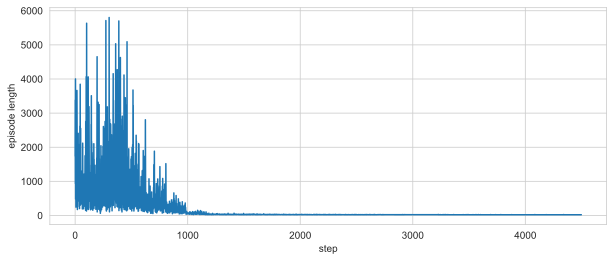

In [45]:
fig = plt.figure(figsize=(10, 4))
subplot = fig.add_subplot(1, 1, 1, xlabel='step', ylabel='episode length')
subplot.plot(range(len(episode_lengths)), episode_lengths)


# Q-Learning

In [46]:
State = Tuple[int, int]

class Agent:
    def __init__(self, maze: Maze) -> None:
        self.maze = maze
        size_y, size_x = len(maze), len(maze[0])
        self.states : List[State] = [(x, y) for x in range(size_x) for y in range(size_y)]
        self.actions : List[State] = [(0, -1), (-1, 0), (1, 0), (0, 1)]
        self.policy : Dict[State, State] = {}
        self.q : Dict[Tuple(State, State), float] = {}
        for state in self.states:
            self.policy[state] = self.actions[np.random.randint(len(self.actions))]
            for action in self.actions:
                self.q[(state, action)] = 0

    def move(self, state: State, action: State) -> Tuple[float, State]:
        x, y = state
        dx, dy = action
        if self.maze[y][x] == 'G':
            return 0, state
        if self.maze[y+dy][x+dx] != "#":
            x += dx
            y += dy
        return -1, (x, y)


def get_episode(agent: Agent, epsilon: float, train: bool) -> List[Tuple[State, State, float]]:
    """startからgoalまでに至るまでの状態変化を返却"""
    episode : List[Tuple[State, State, float]] = []
    state : State = (1, 1)  # start
    while True:
        if np.random.random() < epsilon:  # 確率εでランダムなactionを選択
            action : State = agent.actions[np.random.randint(len(agent.actions))]
        else:
            action : State = agent.policy[state]

        reward, new_state = agent.move(state=state, action=action)
        episode.append((state, action, reward))

        if train:
            # 行動-状態価値関数qと行動ポリシーπの更新
            agent.q[(state, action)] += 0.2 * (reward + agent.q[(new_state, agent.policy[new_state])]) - agent.q[(state, action)]  # α=0.2
            policy_update(agent=agent, state=state)
        x, y = new_state
        if agent.maze[y][x] == 'G':
            break
        state = new_state
    return episode


def policy_update(agent: Agent, state: State) -> None:
    q_max : float = -10**10
    best_action : Optional[State] = None
    for action in agent.actions:
        if agent.q[(state, action)] > q_max:
            q_max = agent.q[(state, action)]
            best_action = action
    agent.policy[state] = best_action


def train(agent: Agent, epsilon: float, num_try: int) -> List[int]:
    episode_lengths : List[int] = [len(get_episode(agent, epsilon, train=True)) for _ in range(num_try)]
    return episode_lengths

In [49]:
maze : Maze = get_maze()
agent : Agent = Agent(maze=maze)

episode_lengths : List[int] = train(agent=agent, epsilon=0.1, num_try=1000)

episode : List[Tuple[State, State, float]] = get_episode(agent=agent, epsilon=0, train=False)
result : Maze = np.copy(agent.maze)
for (state, action, reward) in episode:
    x, y = state
    result[y][x] = '+'
for line in result:
    print(''.join(line))

IndexError: index 10 is out of bounds for axis 0 with size 10